In [1]:
import fsspec

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = Path("data")

## What's the minimum amount of data to achieve r2 > 0.7

In [13]:
diversity

,sequence,consensus_stability_score,diversity
6482,FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM,0.80,0.021739
7753,FEIPDDVPLPAGVEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM,0.47,0.042642
8837,FEIPDDVPLPAGSEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM,0.48,0.042642
9346,FEIPDDVPLPAGMEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM,0.59,0.042642
8077,FEIPDDVPLPAGFEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM,0.72,0.042642
...,...,...,...
7101,KELKKKLEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK,0.80,0.888074
3722,WELKKKLEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK,1.05,0.888078
2991,FELKKKLEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK,1.09,0.888078
3029,MELKKKLEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK,0.86,0.888078


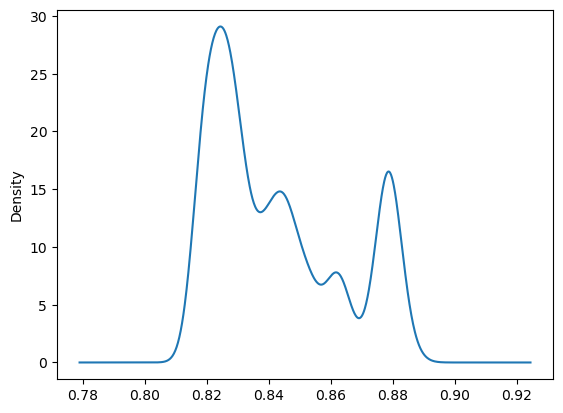

In [14]:
diversity = pd.read_csv(
    data_path / "stability_diversity_full.csv", index_col=0
).sort_values("diversity")
diversity.diversity[1000:].plot.density()
plt.show()

In [3]:
import h5py

with h5py.File(data_path/"stability.h5", "r") as dset:
    X = dset["embeddings"][:]
    y = dset["labels"][:]
    
X.max(), X.mean(), X.std(), X.min()

(4.0821943, 0.006168644, 0.49336722, -17.958618)

## Experiments

In [4]:
from models import ProteinMLP
from train import LitProteins, AttrDict, ProteinStabilityDataset, SubsetDiversitySampler

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

import torch

from pytorch_lightning import loggers as pl_loggers
from typing import List
import shutil


def setup_conf(
    random_percent: float,
    cutoff: float,
    bs: int,
    sampling_dict: dict,
    max_epochs: int,
    train_percent: float = 0.85,
):
    dataset_size = 10281

    conf = AttrDict()
    conf.update(
        {
            "experiment": {"cutoff": cutoff, "random_percent": random_percent},
            "model_name": "ProteinMLP",
            "data": {
                "batch_size": bs,
                "random_split": [
                    int(dataset_size * train_percent),
                    dataset_size - int(dataset_size * train_percent),
                ],
                "sampling": sampling_dict,
            },
            "max_epochs": max_epochs,
            "optimizer": {
                "object": torch.optim.AdamW,
                "name": torch.optim.AdamW.__name__,
                "params": {
                    "lr": 1e-3,
#                     "momentum": 0.7,
#                     "nesterov": True,
                    "weight_decay": 0.01,
                },
                "schedulers": [
#                     {
#                         "object": torch.optim.lr_scheduler.ReduceLROnPlateau,
#                         "name": torch.optim.lr_scheduler.ReduceLROnPlateau.__name__,
#                         "params": {
#                             "patience": 2,
#                         },
#                     },
#                     {
#                         "object": torch.optim.lr_scheduler.CyclicLR,
#                         "name": torch.optim.lr_scheduler.CyclicLR.__name__,
#                         "params": {
#                             "base_lr": 1e-3,
#                             "max_lr": 1e-4,
#                             "cycle_momentum": False,
#                             "step_size_up": 500,
#                         },
#                     },
                    {
                        "object": torch.optim.lr_scheduler.CosineAnnealingLR,
                        "name": torch.optim.lr_scheduler.CosineAnnealingLR.__name__,
                        "params": {
                            "T_max": 70,
                        },
                    },
                ],
            },
        }
    )
    return conf


def setup_data(
    conf: AttrDict,
    sampling: str,
    diversity_cutoff: float,
    max_div_percent: float,
    random_percent: float,
    random_split: List[int],
):
    # update conf
    conf.data["random_split"] = random_split

    conf.data["sampling_name"] = sampling
    conf.data[f"sampling_diversity"] = dict()
    conf.data[f"sampling_diversity"]["diversity_cutoff"] = diversity_cutoff
    conf.data[f"sampling_diversity"]["diversity_path"] = (
        data_path / "stability_diversity_full.csv"
    )
    conf.data[f"sampling_random"] = dict()
    conf.data[f"sampling_random"]["random_percent"] = random_percent

    dataset = ProteinStabilityDataset(data_path / "stability.h5", ret_dict=False)
    train_set, val_set = torch.utils.data.random_split(
        dataset,
        [
            int(len(dataset) * conf.data["random_split"]),
            len(dataset) - int(len(dataset) * conf.data["random_split"]),
        ],
    )

    conf.data[f"sampling_diversity"]["max_size"] = max_div_percent * len(train_set)

    if "diversity" == conf.data[f"sampling_name"]:
        sampler = SubsetDiversitySampler(
            set_indices=train_set.indices, **conf.data["sampling_diversity"]
        )
        print(f"=== USING SubsetDiversitySampler ===")
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY {sampler.stopped_by} ===")

    elif "random" == conf.data[f"sampling_name"]:
        random_percent = conf.data["sampling_random"]["random_percent"]
        sampler = torch.utils.data.SubsetRandomSampler(
            range(int(len(train_set) * random_percent))
        )
        print(f"=== USING SubsetRandomSampler ===")
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY RANDOM PERCENT OF {random_percent} ===")

    else:
        wrong_sampling = conf.data["sampling_name"]
        raise ValueError(f"Sampling Method {wrong_sampling} is not valid.")

    dl_params = {"num_workers": 12, "pin_memory": True}

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=conf.data["batch_size"], sampler=sampler, **dl_params
    )
    valid_loader = torch.utils.data.DataLoader(
        val_set, batch_size=conf.data["batch_size"] * 2, **dl_params
    )

    return {"train_loader": train_loader, "valid_loader": valid_loader}, conf


def setup_trainer(conf, ckpt_dir):
    model = ProteinMLP()
    net = LitProteins(model, conf)

    log_dir = Path(f"logs/{ckpt_dir}")
    ckpt_dir = log_dir / "models"

    if log_dir.exists():
        shutil.rmtree(log_dir)
        log_dir.mkdir()
        ckpt_dir.mkdir()

    trainer = pl.Trainer(
        logger=pl_loggers.TensorBoardLogger(log_dir),
        gpus=1,
        max_epochs=conf.max_epochs,
        log_every_n_steps=5,
        callbacks=[
            ModelCheckpoint(ckpt_dir),
            EarlyStopping(
                monitor="valid_loss_epoch", patience=20, check_on_train_epoch_end=False
            ),
            EarlyStopping(
                monitor="valid_r2_epoch",
                patience=1,
                check_on_train_epoch_end=False,
                stopping_threshold=0.72,
                mode="max",
            ),
            LearningRateMonitor(logging_interval="step"),
        ],
    )

    return {"model": net, "trainer": trainer}, conf


def setup(
    data_path,
    epochs=int(1e4),
    bs=256,
    sampling="diversity",
    diversity_cutoff=0.82,
    max_div_percent=0.9,
    random_percent=0.5,
    ckpt_dir="",
):

    sampling_dict = {}
    conf = setup_conf(
        random_percent=random_percent,
        cutoff=diversity_cutoff,
        bs=bs,
        sampling_dict=sampling_dict,
        max_epochs=epochs,
    )
    data_dict, conf = setup_data(
        conf,
        sampling=sampling,
        diversity_cutoff=diversity_cutoff,
        max_div_percent=max_div_percent,
        random_percent=random_percent,
        random_split=0.8,
    )
    trainer_dict, conf = setup_trainer(conf, ckpt_dir=ckpt_dir)
    experiment_conf = {
        "model": trainer_dict["model"],
        "trainer": trainer_dict["trainer"],
        "train_loader": data_dict["train_loader"],
        "valid_loader": data_dict["valid_loader"],
    }
    return experiment_conf

In [17]:
# using the whole dataset
exp = setup(data_path, epochs=150, sampling="random", random_percent=0.1, ckpt_dir="base")
exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 822 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.1 ===


Validation sanity check: 0it [00:00, ?it/s]

/home/roberto/anaconda3/envs/protera-stability/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
from tqdm import tqdm


def run_experiment(data_path, epochs, max_randoms, cutoffs):

    print("=== RUNNING RANDOM SAMPLING ===")
    for random_percent in tqdm(max_randoms):
        conf = setup_conf(
            random_percent=random_percent,
            cutoff=None,
            bs=256,
            max_epochs=epochs,
            sampling_dict={},
        )
        exp = setup(
            data_path,
            epochs=epochs,
            sampling="random",
            random_percent=random_percent,
            ckpt_dir=f"stability_random_{random_percent}",
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

    print("=== RUNNING DIVERSITY SAMPLING ===")
    for cut in tqdm(cutoffs):
        conf = setup_conf(
            random_percent=random_percent,
            cutoff=cut,
            bs=256,
            max_epochs=epochs,
            sampling_dict={},
        )
        exp = setup(
            data_path,
            epochs=epochs,
            sampling="diversity",
            diversity_cutoff=cut,
            max_div_percent=max_randoms[0],
            ckpt_dir=f"stability_cut_{cut}",
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

In [8]:
random_percents = [0.9, 0.7, 0.5, 0.4, 0.3, 0.2]
cutoffs = [0.75, 0.8, 0.83, 0.84, 0.86]

run_experiment(
    data_path=data_path, epochs=150, max_randoms=random_percents, cutoffs=cutoffs
)

=== RUNNING RANDOM SAMPLING ===


  0%|          | 0/6 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 7401 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.9 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 5756 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.7 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 4112 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.5 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 3289 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.4 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 2467 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.3 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 1644 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.2 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

=== RUNNING DIVERSITY SAMPLING ===


  0%|          | 0/5 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 7402 out of 8224 samples ===
=== SIZE WAS DETERMINED BY MAX SIZE REACHED ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 7402 out of 8224 samples ===
=== SIZE WAS DETERMINED BY MAX SIZE REACHED ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 4405 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 3366 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 1829 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]